### Predicting Cervical Cancer From Biopsy Results
**Shpaner, Leonid - March 1, 2022**

A thorough protocol for cervical cancer detection hinges on cytological tests in conjunction with other methodologies; The focus is narrowed to patients that are healthy vs. unhealthy (based on biopsy results). This predictive modeling endeavor stems from the selection of 858 female patients ages 13-84 from a Venezuelan inpatient clinic. The data is pre-processed; feature selection is based on removal of highly correlated and near zero variance predictors. The data is subsequently partitioned using an 80:20 train-test split ratio to evaluate the model performance of data outside the training set. The class imbalance scenario where the majority of cases are healthy is rebalanced with oversampling. Three models are proposed to aide in establishing the likelihood of being diagnosed with cervical cancer. Results vary based on key performance indicators of the receiver operating characteristics’ areas under their curves. Furthermore, each model is holistically evaluated based on its predictive ability. 

*Keywords:* cervical cancer, machine learning, ensemble methods, predictive modeling

### Loading, Pre-Processing, and Exploring Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable 

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, \
RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from scipy.stats import loguniform, uniform, truncnorm, randint

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://raw.githubusercontent.com/lshpaner/\
MSADS_503_Predictive_Modeling_Predicting_Cervical_Cancer/main/\
code_files/risk_factors_cervical_cancer.csv'

Now, we proceed to read in the flat .csv file, and examine the first 5 rows of data.

In [3]:
df = pd.read_csv(url)
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
# replace original dataframe's ? symbol with nulls
df = df.replace('?', np.nan)

### Features' Data Types and Their Respective Null Counts

In [5]:
print('Number of Rows:', df.shape[0])
print('Number of Columns:', df.shape[1], '\n')
data_types = df.dtypes

data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               df.isnull().sum())
total_null = data_types['Null_Values'].sum()
data_types.reset_index(inplace = True)

data_types = data_types.rename(columns={0:'Data Type',
                          'index': 'Column/Variable',
                          'Null_Values': "# of Nulls"})
data_types

Number of Rows: 858
Number of Columns: 36 



,Column/Variable,Data Type,# of Nulls
0,Age,int64,0
1,Number of sexual partners,object,26
2,First sexual intercourse,object,7
3,Num of pregnancies,object,56
4,Smokes,object,13
5,Smokes (years),object,13
6,Smokes (packs/year),object,13
7,Hormonal Contraceptives,object,108
8,Hormonal Contraceptives (years),object,108
9,IUD,object,117


In [6]:
print ('Total # of Missing Values:', total_null)

Total # of Missing Values: 3622


The following columns have #NA values

In [7]:
df.columns[df.isnull().any()].tolist()

['Number of sexual partners',
 'First sexual intercourse',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:cervical condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:AIDS',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV',
 'STDs: Time since first diagnosis',
 'STDs: Time since last diagnosis']

In [8]:
# drop columns with tests other than Biopsy
cervdat = df.drop(columns=['Citology', 'Schiller', 'Hinselmann'])

In [9]:
# nunmericize features
cervdat = cervdat.apply(pd.to_numeric)
cervdat.dtypes

Age                                     int64
Number of sexual partners             float64
First sexual intercourse              float64
Num of pregnancies                    float64
Smokes                                float64
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives               float64
Hormonal Contraceptives (years)       float64
IUD                                   float64
IUD (years)                           float64
STDs                                  float64
STDs (number)                         float64
STDs:condylomatosis                   float64
STDs:cervical condylomatosis          float64
STDs:vaginal condylomatosis           float64
STDs:vulvo-perineal condylomatosis    float64
STDs:syphilis                         float64
STDs:pelvic inflammatory disease      float64
STDs:genital herpes                   float64
STDs:molluscum contagiosum            float64
STDs:AIDS                         

In [10]:
# inspect number of rows, columns
print('Number of Rows:', cervdat.shape[0])
print('Number of Columns:', cervdat.shape[1], '\n')

Number of Rows: 858
Number of Columns: 33 



### Imputing Missing Values by Median

In [11]:
cervdat = cervdat.fillna(cervdat.median())

In [12]:
var = pd.DataFrame(cervdat.var())
var.reset_index(inplace = True)
var = var.rename(columns={0:'Variance',
                          'index': 'Column/Variable'})
var

,Column/Variable,Variance
0,Age,72.215121
1,Number of sexual partners,2.705232
2,First sexual intercourse,7.794611
3,Num of pregnancies,1.962749
4,Smokes,0.122949
5,Smokes (years),16.488655
6,Smokes (packs/year),4.885653
7,Hormonal Contraceptives,0.215476
8,Hormonal Contraceptives (years),12.723776
9,IUD,0.087481


In [13]:
# drop columns with near zero variance and get shape
cervdat = cervdat.drop(columns=['Smokes (years)', 'Smokes (packs/year)', 
                      'IUD (years)', 'STDs:cervical condylomatosis',
                      'STDs:vaginal condylomatosis',
                      'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                      'STDs:genital herpes', 'STDs:molluscum contagiosum',
                      'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
                      'STDs: Time since first diagnosis', 'Dx:Cancer', 'Dx:HPV',
                      'Dx'])
cervdat.shape

(858, 16)

In [14]:
# encode target to categorical variable

cervdat['Biopsy_Res'] = np.where(cervdat['Biopsy'] > 0, 'Cancer', 'Healthy')

In [15]:
# create dictionary for age ranges

cervdat['Age_Range'] = cervdat['Age'].map({13:'13-17', 14:'13-17', 
15: '13-17', 16:'13-17', 17: '13-17', 18: '18-21', 19: '18-21', 20: '18-21',
21: '18-21', 22: '22-30', 23: '22-30', 24: '22-30', 25: '22-30', 26: '22-30',
27: '22-30', 28: '22-30', 29: '22-30', 30: '22-30', 31: '31-40', 32: '31-40',
33: '31-40', 34: '31-40', 35: '31-40', 36: '31-40', 37: '31-40', 38: '31-40',
39: '31-40', 40: '31-40', 41: '41-50', 42: '41-50', 43: '41-50', 44: '41-50',
45: '41-50', 46: '41-50', 47: '41-50', 48: '41-50', 49: '41-50', 50: '41-50',
51: '51-60', 52: '51-60', 53: '51-60', 53: '51-60', 54: '51-60', 55: '51-60',
56: '51-60', 57: '51-60', 58: '51-60', 58: '51-60', 59: '51-60', 60: '51-60',
61: '61-70', 62: '61-70', 63: '61-70', 64: '61-70', 65: '61-70', 66: '61-70',
67: '61-70', 68: '61-70', 69: '61-70', 70: '61-70', 71: '71-80', 72: '71-80',
73: '71-80', 74: '71-80', 75: '71-80', 76: '71-80', 77: '71-80', 78: '71-80',
79: '71-80', 80: '71-80', 81: '81-90', 82: '81-90', 83: '81-90', 84: '81-90',
85: '81-90', 86: '81-90', 87: '81-90', 87: '81-90', 88: '81-90', 89: '81-90',
90: '81-90'})


## Exploratory Data Analysis (EDA)
 
 

### Distribution: Histograms

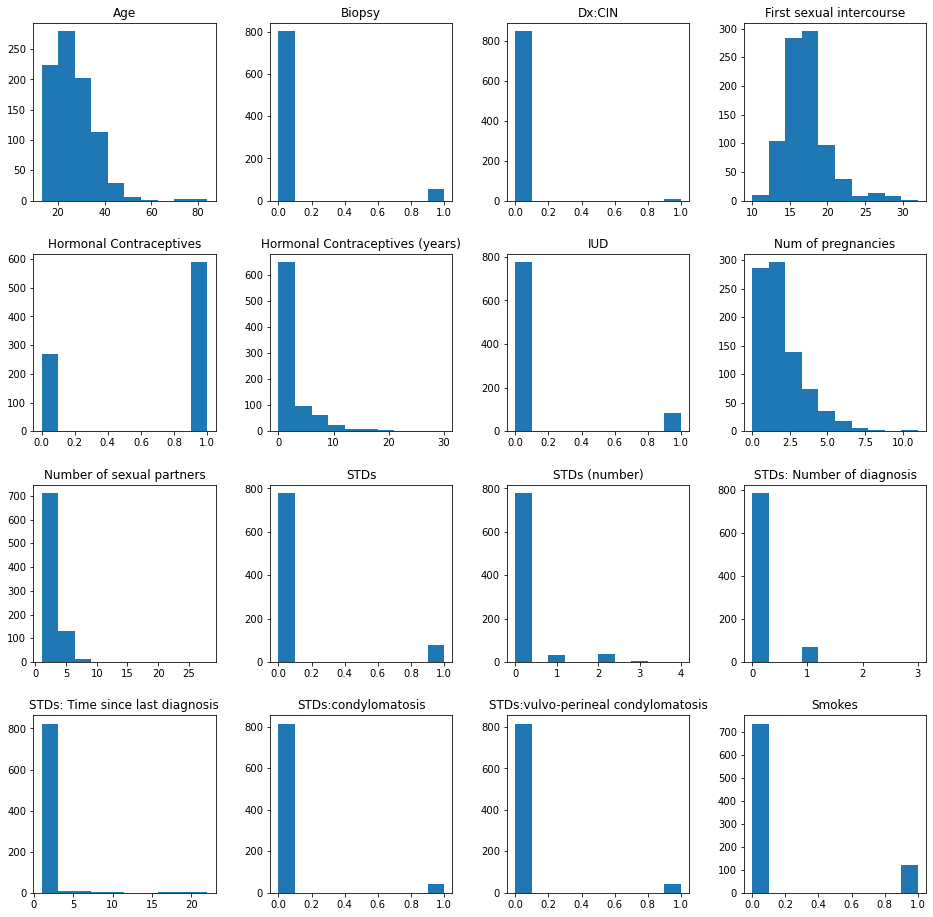

In [16]:
# checking for degenerate distributions

cervdat.hist(grid=False, 
             figsize=(16,16))   
                                 
plt.show()

### Selected Histogram - Age of Female

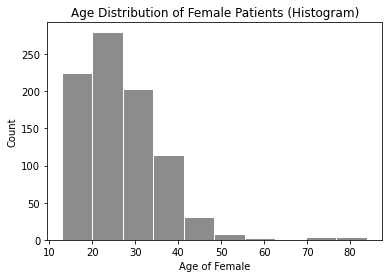

In [17]:
# age bar graph
plt.hist(cervdat['Age'], bins=10, color='gray', alpha=0.9, rwidth=.97)
plt.title('Age Distribution of Female Patients (Histogram)')
plt.xlabel('Age of Female')
plt.ylabel('Count')
plt.show()

### Five Number Summary

In [18]:
# five number summary
age_summary = pd.DataFrame(cervdat['Age'].describe()).T
age_summary

,count,mean,std,min,25%,50%,75%,max
Age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0


In [19]:
print("\033[1m"+'Age Range Summary'+"\033[1m")
def cerv_stats_by_age():
    pd.options.display.float_format = '{:,.2f}'.format
    new2 = cervdat.groupby('Age_Range')['Age']\
    .agg(["mean", "median", "std", "min", "max"])
    new2.loc['Total'] = new2.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = new2.rename(columns = column_rename)
    return dfsummary
cerv_stats_age = cerv_stats_by_age()
cerv_stats_by_age()

Age Range Summary


,Mean,Median,Standard Deviation,Minimum,Maximum
Age_Range,,,,,
13-17,16.01,16.00,1.01,13.00,17.00
18-21,19.47,19.00,1.14,18.00,21.00
22-30,25.84,26.00,2.55,22.00,30.00
31-40,34.69,35.00,2.60,31.00,40.00
41-50,43.62,43.00,2.54,41.00,50.00
51-60,53.50,52.00,3.70,51.00,59.00
61-70,70.00,70.00,0.00,70.00,70.00
71-80,79.00,79.00,nan,79.00,79.00
81-90,84.00,84.00,nan,84.00,84.00


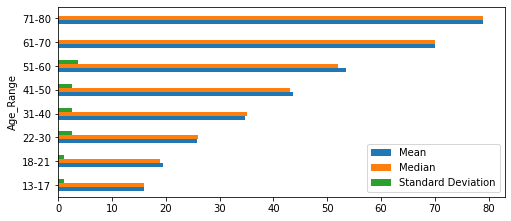

In [20]:
cerv_stats_age.iloc[:, 0:3][0:8].plot.barh(figsize=(8,3.5))
plt.show()

### Boxplot

Boxplot Distribution


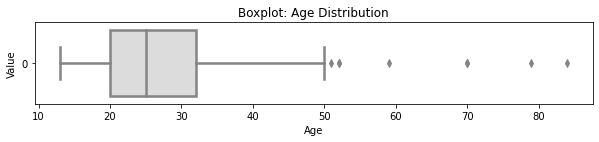

The first quartile is 20.0. 
The third quartile is 32.0. 
The IQR is 12.0.
The mean is 26.82. 
The standard deviation is 8.5. 
The median is 25.0. 


In [21]:
# selected boxplot distributions
print("\033[1m"+'Boxplot Distribution'+"\033[1m")

# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (10,1.5))
plt.title ('Boxplot: Age Distribution')
plt.xlabel('Age')
plt.ylabel('Value')
sns.boxplot(data=cervdat['Age'], 
            palette="coolwarm", orient='h', 
            linewidth=2.5)
plt.show()

IQR = age_summary['75%'][0] - age_summary['25%'][0]

print('The first quartile is %s. '%age_summary['25%'][0])
print('The third quartile is %s. '%age_summary['75%'][0])
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s. '%round(age_summary['mean'][0],2))
print('The standard deviation is %s. '%round(age_summary['std'][0],2))
print('The median is %s. '%round(age_summary['50%'][0],2))

### Contingency Table

In [22]:
def age_biopsy():
	
	Biopsy_Res_healthy = cervdat.loc[cervdat.Biopsy_Res == 'Healthy'].groupby(
		['Age_Range'])[['Biopsy_Res']].count()
	Biopsy_Res_healthy.rename(columns = {'Biopsy_Res':'Healthy'}, inplace=True)
	Biopsy_Res_cancer= cervdat.loc[cervdat.Biopsy_Res == 'Cancer'].groupby(
		['Age_Range'])[['Biopsy_Res']].count()
	Biopsy_Res_cancer.rename(columns = {'Biopsy_Res':'Cancer'}, inplace=True)
	Biopsy_Res_comb = pd.concat([Biopsy_Res_healthy, Biopsy_Res_cancer], axis=1)
	# sum row totals
	Biopsy_Res_comb['Total']=Biopsy_Res_comb.sum(axis=1)
	Biopsy_Res_comb.loc['Total']=Biopsy_Res_comb.sum(numeric_only=True, axis=0)
	# get % total of each row
	Biopsy_Res_comb['% Cancer']=round((Biopsy_Res_comb['Cancer'] / 
	(Biopsy_Res_comb['Cancer']+Biopsy_Res_comb['Healthy']))* 100, 2)
	Biopsy_Res_comb['Cancer']=Biopsy_Res_comb['Cancer'].fillna(0)
	Biopsy_Res_comb['% Cancer']=Biopsy_Res_comb['% Cancer'].fillna(0)
	return Biopsy_Res_comb.style.format("{:,.0f}")
age_biopsy()
age_biopsy = age_biopsy().data; age_biopsy	

,Healthy,Cancer,Total,% Cancer
13-17,83.00,2.00,85.00,2.35
18-21,171.00,14.00,185.00,7.57
22-30,318.00,20.00,338.00,5.92
31-40,182.00,15.00,197.00,7.61
41-50,43.00,2.00,45.00,4.44
51-60,2.00,2.00,4.00,50.00
61-70,2.00,0.00,2.00,0.00
71-80,1.00,0.00,1.00,0.00
81-90,1.00,0.00,1.00,0.00
Total,803.00,55.00,858.00,6.41


### Bar Graphs

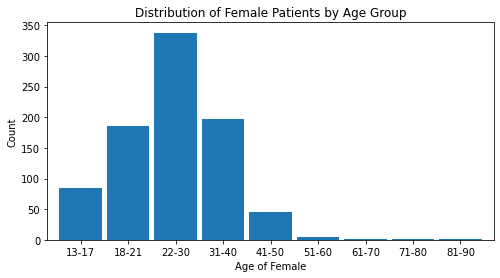

In [23]:
age_range_plt = age_biopsy['Total'][0:9]
age_range_plt.plot(kind='bar', width=0.90, figsize=(8,4))
plt.title('Distribution of Female Patients by Age Group')
plt.xlabel('Age of Female'); plt.xticks(rotation = 0)
plt.ylabel('Count'); plt.show()

*Note.* The age range 22-30 has the largest number of observations in this dataset.

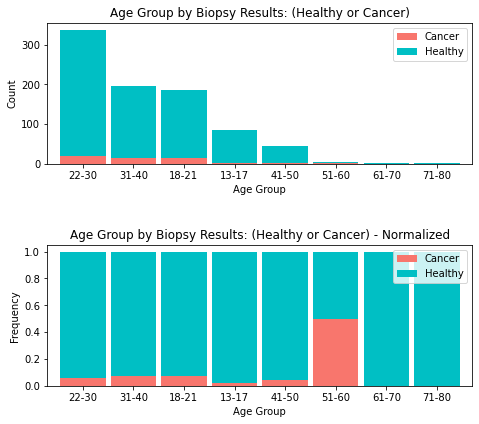

In [24]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211); ax2 = fig.add_subplot(212); fig.tight_layout(pad=6)
age_range_plt2= age_biopsy [['Cancer', 'Healthy']][0:8].sort_values(by=['Cancer'], 
                                                   ascending=False)
age_range_plt2.plot(kind='bar', stacked=True, 
              ax=ax1, color = ['#F8766D', '#00BFC4'], width = 0.90)
ax1.set_title('Age Group by Biopsy Results: (Healthy or Cancer)')
ax1.set_xlabel('Age Group'); ax1.set_ylabel('Count')
for tick in ax1.get_xticklabels():
    tick.set_rotation(0)

# normalize the plot
age_range_plt_norm = age_range_plt2.div(age_range_plt2.sum(1), axis = 0)
age_range_plt_norm.plot(kind='bar', stacked=True, 
                  ax=ax2,color = ['#F8766D', '#00BFC4'], width = 0.90)
ax2.set_title('Age Group by Biopsy Results: (Healthy or Cancer) - Normalized')
ax2.set_xlabel('Age Group'); ax2.set_ylabel('Frequency')
for tick in ax2.get_xticklabels():
    tick.set_rotation(0)

### Addressing Multicollinearity

Cervical Cancer Data: Correlation Matrix


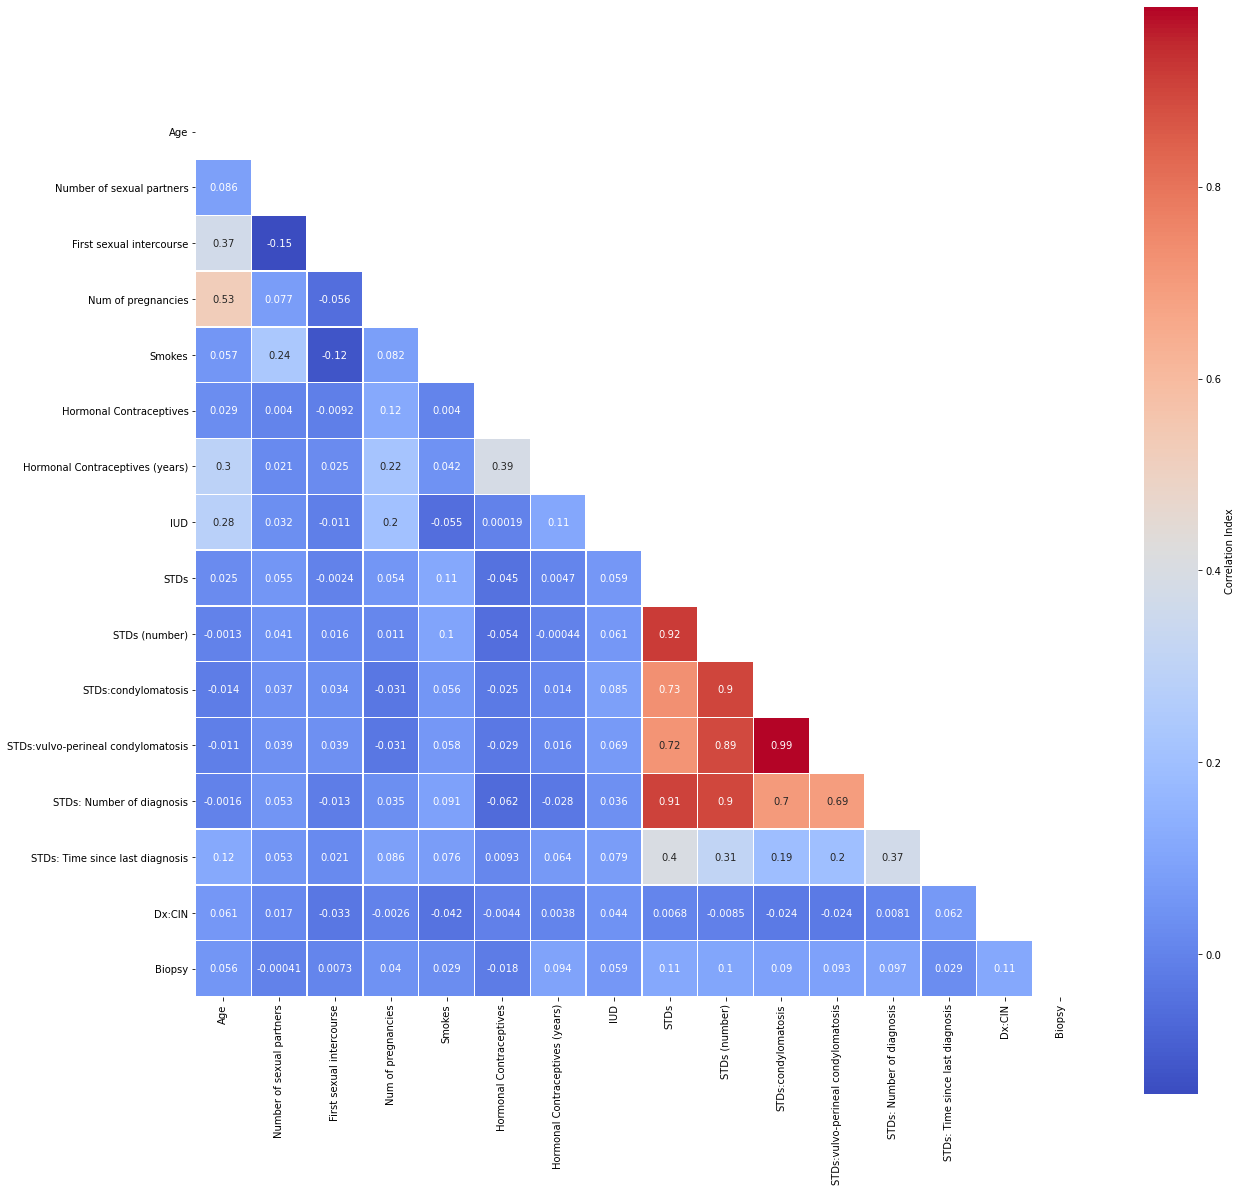

In [25]:
# correlation matrix title
print("\033[1m"+'Cervical Cancer Data: Correlation Matrix'+"\033[1m")
# assign correlation function to new variable
corr = cervdat.corr()
matrix = np.triu(corr) # for triangular matrix
plt.figure(figsize=(20,20))
# parse corr variable intro triangular matrix
sns.heatmap(cervdat.corr(method='pearson'), 
            annot=True, linewidths=.5, cmap="coolwarm", mask=matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'})
plt.show()

Let us narrow our focus by removing highly correlated predictors and passing the rest into a new dataframe.

In [26]:
cor_matrix = cervdat.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                     k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if 
           any(upper_tri[column] > 0.75)]
print('These are the columns we should drop: %s'%to_drop)

These are the columns we should drop: ['STDs (number)', 'STDs:condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs: Number of diagnosis']


In [27]:
cervdat1 = cervdat.drop(columns = ['STDs (number)', 'STDs:condylomatosis', 
                                   'STDs:vulvo-perineal condylomatosis', 
                                   'STDs: Number of diagnosis', 'Age_Range', 
                                   'Biopsy_Res'])
cervdat1.shape[1]

12

### Class Imbalance

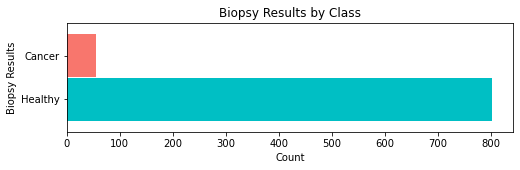

Healthy    803
Cancer      55
Name: Biopsy_Res, dtype: int64


In [28]:
# biopsy bar graph
biopsy_count = cervdat['Biopsy_Res'].value_counts()

biopsy_count.plot.barh(x ='lab', y='val', rot=0, width=0.99, 
                       color = ['#00BFC4', '#F8766D'], figsize=(8,2))
plt.title ('Biopsy Results by Class')
plt.xlabel('Count'); plt.ylabel('Biopsy Results')
plt.show()
print(biopsy_count)

In [29]:
pca = PCA(n_components=2, random_state=222)
data_2d = pd.DataFrame(pca.fit_transform(cervdat1.iloc[:,0:11]))

In [30]:
data_2d= pd.concat([data_2d, cervdat1['Biopsy']], axis=1)
data_2d.columns = ['x', 'y', 'Biopsy']; data_2d

,x,y,Biopsy
0,-9.26,-0.58,0
1,-12.36,-0.06,0
2,6.59,-2.93,0
3,24.80,-1.71,0
4,21.25,9.54,0
...,...,...,...
853,6.66,-3.15,0
854,6.04,4.70,0
855,-2.26,-1.76,0
856,6.62,-4.09,0


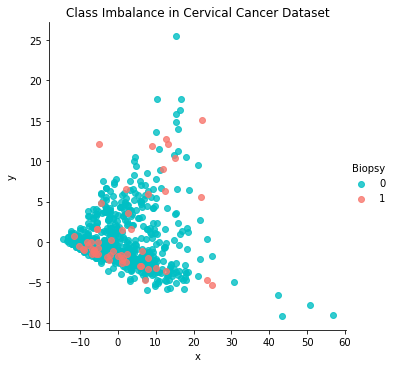

In [31]:
sns.lmplot('x','y',data_2d,fit_reg=False,hue='Biopsy',palette=['#00BFC4','#F8766D'])
plt.title('Class Imbalance in Cervical Cancer Dataset'); plt.show()

In [32]:
ada = ADASYN(random_state=222)
X_resampled, y_resampled = ada.fit_resample(cervdat1.iloc[:,0:11], cervdat1['Biopsy'])

In [33]:
cervdat2 = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
cervdat2.columns = cervdat1.columns

In [34]:
cervdat2['Biopsy'].value_counts()

0    803
1    799
Name: Biopsy, dtype: int64

### Checking for Statistical Significance Via Baseline Mode

The logistic regression model is introduced as a baseline because establishing impact of coefficients on each independent feature can be carried with relative ease. Moreover, it is possible to gauge statistical significance from the reported *p*-values of the summary output table below.

Generalized Linear Model - Logistic Regression Baseline

$$y = \beta_0 + \beta_1x_1 +\beta_2x_2 +\cdots+\beta_px_p + \varepsilon$$

Logistic Regression - Parametric Form

$$p(y) = \frac{\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}{1+\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}  + \varepsilon$$

Logistic Regression - Descriptive Form

$$\hat{p}\text{(Cancer)} = \frac{\text{exp}(b_0+b_1(\text{Age})+b_2\text{(No. Partners)}+\cdot\cdot\cdot+b_px_p)}{1+\text{exp}(b_0+b_1\text{(Age)}+b_2\text{(No. Partners)}+\cdot\cdot\cdot+b_px_p)}$$

In [35]:
X1 = cervdat2.drop(columns=['Biopsy'])
X1 = sm.add_constant(X1)
y1 = pd.DataFrame(cervdat2[['Biopsy']])
log_results = sm.Logit(y1,X1, random_state=222).fit()
log_results.summary()

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Biopsy   No. Observations:                 1602
Model:                          Logit   Df Residuals:                     1590
Method:                           MLE   Df Model:                           11
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                 0.06986
Time:                        21:49:28   Log-Likelihood:                -1032.8
converged:                       True   LL-Null:                       -1110.4
Covariance Type:            nonrobust   LLR p-value:                 1.322e-27
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0388      0.443     -0.087      0.930      -0.908       0.830
Age                                -0.0239      0.010     -2.471      0.013      -0.043      -0.005
Number of sexual partners           0.0210      0.039      0.541      0.588      -0.055       0.097
First sexual intercourse            0.0216      0.026      0.845      0.398      -0.029       0.072
Num of pregnancies                  0.1540      0.054      2.877      0.004       0.049       0.259
Smokes                             -0.0910      0.172     -0.530      0.596      -0.428       0.246
Hormonal Contraceptives            -0.5927      0.134     -4.421      0.000      -0.855      -0.330
Hormonal Contraceptives (years)     0.1042      0.016      6.456      0.000       0.073       0.136
IUD                                 0.6167      0.196      3.154      0.002       0.234       1.000
STDs                                1.7231      0.200      8.606      0.000       1.331       2.115
STDs: Time since last diagnosis    -0.0800      0.031     -2.555      0.011      -0.141      -0.019
Dx:CIN                             -0.4723      0.722     -0.654      0.513      -1.887       0.943
===================================================================================================
"""

From the summary output table, we observe that `Number of sexual partners`, `First sexual intercourse`, `Smokes`, and `Dx:CIN` have *p*-values of 0.588, 0.398, 0.596, and 0.513, respectively, thereby making these variables non-statistically significant where α = 0.05. We will thus remove them from the refined dataset.

In [36]:
cervdat2 = cervdat2.drop(columns=['Number of sexual partners', 'First sexual intercourse', 'Smokes', 'Dx:CIN'])

### Train_Test_Split

In [37]:
X = cervdat2.drop(columns=['Biopsy'])
y = pd.DataFrame(cervdat2['Biopsy'])

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, 
                                                    random_state=42)

# confirming train_test_split proportions
print('training size:', round(len(X_train)/len(X),2))
print('test size:', round(len(X_test)/len(X),2))

training size: 0.8
test size: 0.2


In [38]:
# confirm dimensions (size of newly partioned data)
print('Training:', len(X_train))
print('Test:', len(X_test))
print('Total:', len(X_train) + len(X_test))

Training: 1281
Test: 321
Total: 1602


## Model Building Strategies

### Logistic Regression

In [39]:
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

model = LogisticRegression(random_state=222)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=222)
space = dict()
# define search space
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', 
n_jobs=-1, cv=cv, random_state=222)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6434875645994832
Best Hyperparameters: {'C': 0.07972630225526722, 'penalty': 'l1', 'solver': 'liblinear'}


Cost = 0.01 	 Testing Accuracy = 0.53 	     Training Accuracy = 0.49
Cost = 0.10 	 Testing Accuracy = 0.65 	     Training Accuracy = 0.65
Cost = 0.20 	 Testing Accuracy = 0.64 	     Training Accuracy = 0.65
Cost = 0.50 	 Testing Accuracy = 0.64 	     Training Accuracy = 0.65
Cost = 0.80 	 Testing Accuracy = 0.64 	     Training Accuracy = 0.65
Cost = 1.00 	 Testing Accuracy = 0.63 	     Training Accuracy = 0.65
Cost = 5.00 	 Testing Accuracy = 0.63 	     Training Accuracy = 0.65
Cost = 10.00 	 Testing Accuracy = 0.63 	     Training Accuracy = 0.65
Cost = 20.00 	 Testing Accuracy = 0.63 	     Training Accuracy = 0.65
Cost = 50.00 	 Testing Accuracy = 0.63 	     Training Accuracy = 0.65


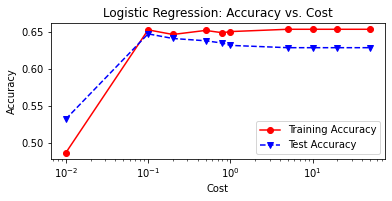

In [40]:
# Manually Tuning The Logistic Regression Model
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRtestAcc = []
for param in C:
    tuned_lr = LogisticRegression(solver = 'liblinear',
                                  C = param,
                                  max_iter = 500,
                                  penalty = 'l1',
                                  n_jobs = -1,
                                  random_state = 222)
    tuned_lr.fit(X_train, y_train)
    # Predict on train set
    tuned_lr_pred_train = tuned_lr.predict(X_train)
    # Predict on test set
    tuned_lr1 = tuned_lr.predict(X_test)
    LRtrainAcc.append(accuracy_score(y_train, tuned_lr_pred_train))
    LRtestAcc.append(accuracy_score(y_test, tuned_lr1))
    print('Cost = %2.2f \t Testing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (param,accuracy_score(y_test,tuned_lr1),
                               accuracy_score(y_train,tuned_lr_pred_train)))

# plot cost by accuracy
fig, ax = plt.subplots(figsize=(6,2.5))
ax.plot(C, LRtrainAcc, 'ro-', C, LRtestAcc,'bv--')
ax.legend(['Training Accuracy','Test Accuracy'])
plt.title('Logistic Regression: Accuracy vs. Cost')
ax.set_xlabel('Cost'); ax.set_xscale('log')
ax.set_ylabel('Accuracy'); plt.show()

In [41]:
# Un-Tuned Logistic Regression Model
logit_reg = LogisticRegression(random_state=222) 
logit_reg.fit(X_train, y_train)

# Predict on test set
logit_reg_pred1 = logit_reg.predict(X_test)


# accuracy and classification report (Untuned Model)
print('Untuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_test, logit_reg_pred1))
print('Classification Report \n', 
       classification_report(y_test, logit_reg_pred1))


# Tuned Logistic Regression Model

tuned_logreg = LogisticRegression(solver = 'liblinear',
                                  C = 0.08,
                                  penalty = 'l1',
                                  max_iter = 500,
                                  n_jobs = -1,
                                  random_state=42)
tuned_logreg.fit(X_train, y_train)
logreg_pred = tuned_logreg.predict(X_test)

# accuracy and classification report (Tuned Model)
print('Tuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_test, logreg_pred))
print('Classification Report \n', 
       classification_report(y_test, logreg_pred))

Untuned Logistic Regression Model
Accuracy Score
0.6292834890965732
Classification Report 
               precision    recall  f1-score   support

           0       0.64      0.72      0.67       172
           1       0.62      0.53      0.57       149

    accuracy                           0.63       321
   macro avg       0.63      0.62      0.62       321
weighted avg       0.63      0.63      0.63       321

Tuned Logistic Regression Model
Accuracy Score
0.6510903426791277
Classification Report 
               precision    recall  f1-score   support

           0       0.65      0.75      0.70       172
           1       0.65      0.54      0.59       149

    accuracy                           0.65       321
   macro avg       0.65      0.64      0.64       321
weighted avg       0.65      0.65      0.65       321



### Random Forest

In [42]:
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, 
    # with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation 
# (500 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=100, 
                         cv=5, scoring='accuracy', random_state=222)

# train the random search meta-estimator to find the 
# best model out of 100 candidates
result2 = clf.fit(X_train, y_train)

# print winning set of hyperparameters
from pprint import pprint
print('Best Score: %s' % result2.best_score_)
pprint(result2.best_estimator_.get_params())

Best Score: 0.9149015077821012
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': array([0.34617443]),
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.021034408339180924,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 139,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Max Depth =  1 	 Test Accuracy = 0.70 	     Training Accuracy = 0.73
Max Depth =  2 	 Test Accuracy = 0.75 	     Training Accuracy = 0.77
Max Depth =  3 	 Test Accuracy = 0.82 	     Training Accuracy = 0.84
Max Depth =  4 	 Test Accuracy = 0.83 	     Training Accuracy = 0.86
Max Depth =  5 	 Test Accuracy = 0.88 	     Training Accuracy = 0.92
Max Depth =  6 	 Test Accuracy = 0.90 	     Training Accuracy = 0.92
Max Depth =  7 	 Test Accuracy = 0.91 	     Training Accuracy = 0.94
Max Depth =  8 	 Test Accuracy = 0.92 	     Training Accuracy = 0.95
Max Depth =  9 	 Test Accuracy = 0.93 	     Training Accuracy = 0.95
Max Depth = 10 	 Test Accuracy = 0.93 	     Training Accuracy = 0.97
Max Depth = 11 	 Test Accuracy = 0.95 	     Training Accuracy = 0.97
Max Depth = 12 	 Test Accuracy = 0.96 	     Training Accuracy = 0.98
Max Depth = 13 	 Test Accuracy = 0.95 	     Training Accuracy = 0.98
Max Depth = 14 	 Test Accuracy = 0.95 	     Training Accuracy = 0.99


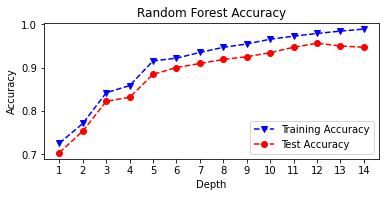

In [43]:
# Random Forest Tuning (Manual)
rf_train_accuracy = []
rf_test_accuracy = []
for n in range(1, 15):
    rf = RandomForestClassifier(max_depth = n, 
                                random_state=222)
    rf = rf.fit(X_train, y_train)
    rf_pred_train = rf.predict(X_train)
    rf_pred_test = rf.predict(X_test)
    rf_train_accuracy.append(accuracy_score(y_train, 
                                            rf_pred_train))
    rf_test_accuracy.append(accuracy_score(y_test, 
                                            rf_pred_test))
    print('Max Depth = %2.0f \t Test Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (n, accuracy_score(y_test,
                                                  rf_pred_test),
                               accuracy_score(y_train,
                                              rf_pred_train)))
max_depth = list(range(1, 15))
fig, plt.subplots(figsize=(6,2.5))
plt.plot(max_depth, rf_train_accuracy, 'bv--', 
         label='Training Accuracy')
plt.plot(max_depth, rf_test_accuracy, 'ro--', 
         label='Test Accuracy')
plt.title('Random Forest Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth)
plt.legend()
plt.show()

In [44]:
# Untuned Random Forest
untuned_rf = RandomForestClassifier(random_state=222)
untuned_rf = untuned_rf.fit(X_train, y_train)

# Predict on test set
untuned_rf1 = untuned_rf.predict(X_test)

# accuracy and classification report
print('Untuned Random Forest Model')
print('Accuracy Score')
print(accuracy_score(y_test, untuned_rf1))
print('Classification Report \n', 
       classification_report(y_test, untuned_rf1))

# Tuned Random Forest
tuned_rf = RandomForestClassifier(random_state=222,
                                  max_depth = 12)
tuned_rf = tuned_rf.fit(X_train, y_train)

# Predict on test set
tuned_rf1 = tuned_rf.predict(X_test)

# accuracy and classification report
print('Tuned Random Forest Model')
print('Accuracy Score')
print(accuracy_score(y_test, tuned_rf1))
print('Classification Report \n', 
       classification_report(y_test, tuned_rf1))

Untuned Random Forest Model
Accuracy Score
0.9532710280373832
Classification Report 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       172
           1       0.97      0.93      0.95       149

    accuracy                           0.95       321
   macro avg       0.95      0.95      0.95       321
weighted avg       0.95      0.95      0.95       321

Tuned Random Forest Model
Accuracy Score
0.956386292834891
Classification Report 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       172
           1       0.97      0.93      0.95       149

    accuracy                           0.96       321
   macro avg       0.96      0.95      0.96       321
weighted avg       0.96      0.96      0.96       321



### Support Vector Machines 
Similar to that of logistic regression, a linear support vector machine model relies on estimating $(w^*,b^*)$ visa vie constrained optimization of the following form:

\begin{eqnarray*}
&&\min_{w^*,b^*,\{\xi_i\}} \frac{\|w\|^2}{2} + \frac{1}{C} \sum_i \xi_i \\
\textrm{s.t.} && \forall i: y_i\bigg[w^T \phi(x_i) + b\bigg] \ge 1 - \xi_i, \ \ \xi_i \ge 0  
\end{eqnarray*}

However, our endeavor relies on the radial basis function kernel:

$$ K(x,x^{'}) = \text{exp} \left(-\frac{||x-x^{'}||^2}{2\sigma^2} \right) $$

where $||x-x^{'}||^2$ is the squared Euclidean distance between the two feature vectors, and $\gamma = \frac{1}{2\sigma^2}$.

Simplifying the equation we have:

$$ K(x,x^{'}) = \text{exp} (-\gamma ||x-x^{'}||^2) $$


### SVM (Radial Basis Function) Model

In [45]:
svm1 = SVC(kernel='rbf', random_state=222)
svm1.fit(X_train, y_train)
svm1_pred_test = svm1.predict(X_test)
print('accuracy = %2.2f ' % accuracy_score(y_test, svm1_pred_test))

accuracy = 0.56 


### Setting (tuning) the gamma hyperparameter to "auto"

In [46]:
svm2 = SVC(kernel='rbf', gamma='auto', random_state=222)
svm2.fit(X_train, y_train)
svm2_pred_test = svm2.predict(X_test)
print('accuracy = %2.2f ' % accuracy_score(svm2_pred_test,y_test))

accuracy = 0.78 


Cost = 0.01 	 Testing Accuracy = 0.46 	     Training Accuracy = 0.51
Cost = 0.10 	 Testing Accuracy = 0.74 	     Training Accuracy = 0.78
Cost = 0.20 	 Testing Accuracy = 0.76 	     Training Accuracy = 0.80
Cost = 0.50 	 Testing Accuracy = 0.79 	     Training Accuracy = 0.84
Cost = 0.80 	 Testing Accuracy = 0.79 	     Training Accuracy = 0.85
Cost = 1.00 	 Testing Accuracy = 0.78 	     Training Accuracy = 0.85
Cost = 5.00 	 Testing Accuracy = 0.82 	     Training Accuracy = 0.90
Cost = 10.00 	 Testing Accuracy = 0.82 	     Training Accuracy = 0.91
Cost = 20.00 	 Testing Accuracy = 0.83 	     Training Accuracy = 0.92
Cost = 50.00 	 Testing Accuracy = 0.87 	     Training Accuracy = 0.94


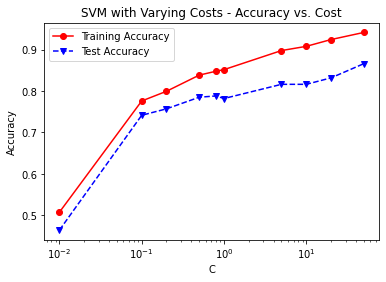

In [47]:
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
svm3_trainAcc = []
svm3_testAcc = []

for param in C:
    svm3 = SVC(C=param,kernel='rbf', gamma = 'auto', random_state=42)
    svm3.fit(X_train, y_train)
    svm3_pred_train = svm3.predict(X_train)
    svm3_pred_test = svm3.predict(X_test)
    svm3_trainAcc.append(accuracy_score(y_train, svm3_pred_train))
    svm3_testAcc.append(accuracy_score(y_test, svm3_pred_test))
    print('Cost = %2.2f \t Testing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (param,accuracy_score(y_test,svm3_pred_test),
                                 accuracy_score(y_train,svm3_pred_train)))    

fig, ax = plt.subplots()
ax.plot(C, svm3_trainAcc, 'ro-', C, svm3_testAcc,'bv--')
ax.legend(['Training Accuracy','Test Accuracy'])
plt.title('SVM with Varying Costs - Accuracy vs. Cost')
ax.set_xlabel('C')
ax.set_xscale('log')
ax.set_ylabel('Accuracy')
plt.show()

In [48]:
# Untuned Support Vector Machine
untuned_svm = SVC(random_state=222)
untuned_svm = untuned_svm.fit(X_train, y_train)

# Predict on test set
untuned_svm1 = untuned_svm.predict(X_test)

# accuracy and classification report
print('Untuned Support Vector Machine Model')
print('Accuracy Score')
print(accuracy_score(y_test, untuned_svm1))
print('Classification Report \n', 
       classification_report(y_test, untuned_svm1))

# Tuned Support Vector Machine
tuned_svm = SVC(kernel='rbf', 
                gamma='auto', 
                random_state=222,
                C = 50, probability = True)
tuned_svm = tuned_svm.fit(X_train, y_train)

# Predict on test set
tuned_svm1 = tuned_svm.predict(X_test)

# accuracy and classification report
print('Tuned Support Vector Machine Model')
print('Accuracy Score')
print(accuracy_score(y_test, tuned_svm1))
print('Classification Report \n', 
       classification_report(y_test, tuned_svm1))

Untuned Support Vector Machine Model
Accuracy Score
0.557632398753894
Classification Report 
               precision    recall  f1-score   support

           0       0.56      0.87      0.68       172
           1       0.57      0.20      0.30       149

    accuracy                           0.56       321
   macro avg       0.56      0.53      0.49       321
weighted avg       0.56      0.56      0.50       321

Tuned Support Vector Machine Model
Accuracy Score
0.8660436137071651
Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       172
           1       0.83      0.90      0.86       149

    accuracy                           0.87       321
   macro avg       0.87      0.87      0.87       321
weighted avg       0.87      0.87      0.87       321



## Model Evaluation

### Confusion Matrices

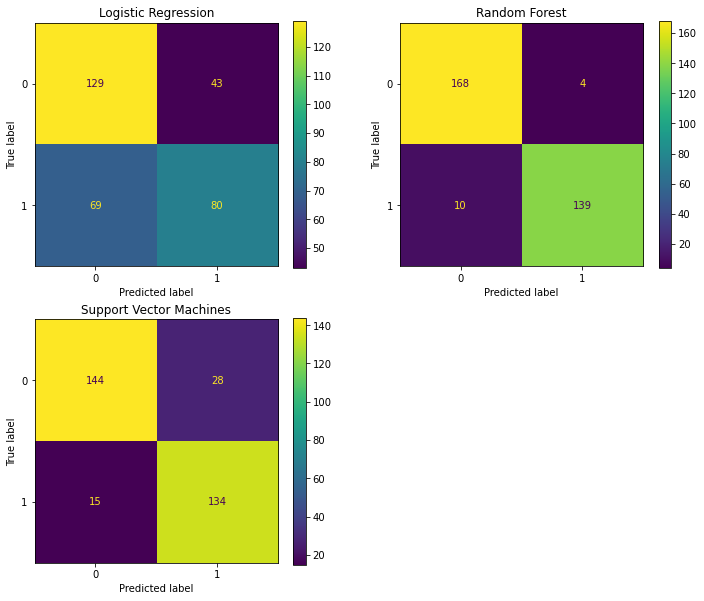

In [49]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

# logistic regression confusion matrix
plot_confusion_matrix(tuned_logreg, X_test, y_test, ax=ax1)
ax1.set_title('Logistic Regression')

# Decision tree confusion matrix
plot_confusion_matrix(tuned_rf, X_test, y_test, ax=ax2)
ax2.set_title('Random Forest')

# random forest confusion matrix
plot_confusion_matrix(tuned_svm, X_test, y_test, ax=ax3)
ax3.set_title('Support Vector Machines')
plt.show()

### ROC Curves

In [50]:
lr_pred = tuned_logreg.predict_proba(X_test)[:, 1]
rf_pred = tuned_rf.predict_proba(X_test)[:, 1]
svm_pred = tuned_svm.predict_proba(X_test)[:, 1]

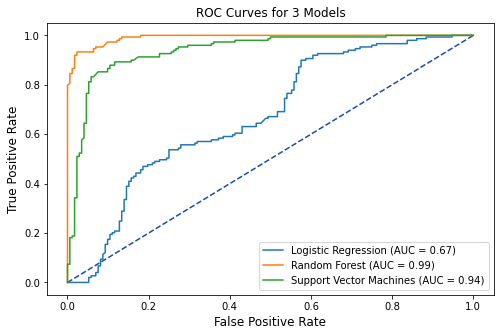

In [51]:
# plot all of the roc curves on one graph
tuned_lr_roc = metrics.roc_curve(y_test,lr_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_test,lr_pred)
tuned_lr_auc = metrics.auc(fpr, tpr)
tuned_lr_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, 
roc_auc = tuned_lr_auc, 
estimator_name = 'Logistic Regression')

tuned_rf1_roc = metrics.roc_curve(y_test,rf_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_test,rf_pred)
tuned_rf1_auc = metrics.auc(fpr, tpr)
tuned_rf1_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,
roc_auc=tuned_rf1_auc, 
estimator_name = 'Random Forest')

tuned_svm1_roc = metrics.roc_curve(y_test, svm_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_test,svm_pred)
tuned_svm1_auc = metrics.auc(fpr, tpr)
tuned_svm1_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, 
roc_auc=tuned_svm1_auc, 
estimator_name = 'Support Vector Machines')

# plot set up
fig, ax = plt.subplots(figsize=(8,5))
plt.title('ROC Curves for 3 Models',fontsize=12)
plt.plot([0, 1], [0, 1], linestyle = '--', 
         color = '#174ab0')
plt.xlabel('',fontsize=12) 
plt.ylabel('',fontsize=12) 

# Model ROC Plots Defined above
tuned_lr_plot.plot(ax)
tuned_rf1_plot.plot(ax)
tuned_svm1_plot.plot(ax)
plt.show()

### Performance Metrics

In [52]:
# Logistic Regression Performance Metrics
report1 = classification_report(y_test, logreg_pred, output_dict=True)
accuracy1 = round(report1['accuracy'],4)
precision1 = round(report1['1']['precision'],4)
recall1 = round(report1['1']['recall'],4)
fl_score1 = round(report1['1']['f1-score'],4)

# Decision Tree Performance Metrics                       
report2 = classification_report(y_test,tuned_rf1, output_dict=True)
accuracy2 = round(report2['accuracy'],4)
precision2 = round(report2['1']['precision'],4)
recall2 = round(report2['1']['recall'],4)
fl_score2 = round(report2['1']['f1-score'],4)

# Random Forest Performance Metrics
report3 = classification_report(y_test,tuned_svm1,output_dict=True)                
accuracy3 = round(report3['accuracy'],4)
precision3 = round(report3['1']['precision'],4)
recall3 = round(report3['1']['recall'],4)
fl_score3 = round(report3['1']['f1-score'],4)   

In [53]:
table1 = PrettyTable()
table1.field_names = ['Model', 'Test Accuracy', 
'Precision', 'Recall', 
                      'F1-score']
table1.add_row(['Logistic Regression', accuracy1, 
                precision1, recall1, fl_score1])
table1.add_row(['Random Forest', accuracy2, 
                precision2, recall2, fl_score2])
table1.add_row(['Support Vector Machines', accuracy3, 
                precision3, recall3, fl_score3])
print(table1)

+-------------------------+---------------+-----------+--------+----------+
|          Model          | Test Accuracy | Precision | Recall | F1-score |
+-------------------------+---------------+-----------+--------+----------+
|   Logistic Regression   |     0.6511    |   0.6504  | 0.5369 |  0.5882  |
|      Random Forest      |     0.9564    |   0.972   | 0.9329 |  0.9521  |
| Support Vector Machines |     0.866     |   0.8272  | 0.8993 |  0.8617  |
+-------------------------+---------------+-----------+--------+----------+


In [54]:
# Mean-Squared Errors
mse1 = round(mean_squared_error(y_test, logreg_pred),4)
mse2 = round(mean_squared_error(y_test, tuned_rf1),4)
mse3 = round(mean_squared_error(y_test, tuned_svm1),4)

table2 = PrettyTable()
table2.field_names = ['Model', 'AUC', 'MSE']
table2.add_row(['Logistic Regression', 
                 round(tuned_lr_auc,4), mse1])
table2.add_row(['Random Forest', 
                 round(tuned_rf1_auc,4), mse2])
table2.add_row(['Support Vector Machines', 
                 round(tuned_svm1_auc,4), mse3])
print(table2)

+-------------------------+--------+--------+
|          Model          |  AUC   |  MSE   |
+-------------------------+--------+--------+
|   Logistic Regression   | 0.6744 | 0.3489 |
|      Random Forest      | 0.9913 | 0.0436 |
| Support Vector Machines | 0.9378 | 0.134  |
+-------------------------+--------+--------+


**References**

Brownlee, J. (2020, July 24). Train-Test Split for Evaluating Machine Learning Algorithms. Machine Learning Mastery.
https://machinelearningmastery.com/train-test-split-forevaluating-machine-learning-algorithms/

Centers for Disease Control and Prevention. (2021, January 12). What Are the Risk Factors for Cervical Cancer?
https://www.cdc.gov/cancer/cervical/basic_info/risk_factors.htm

Dua, D., & Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml].
Irvine, CA: University of California, School of Information and Computer Science.
https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29

Kelwin F., Cardoso, J.S., and Fernandes, J. (2017). Transfer Learning with Partial Observability Applied to Cervical Cancer Screening.
Springer International Publishing, 1055, 243-250. https://www.doi.org/10.1007/978-3-319-58838-4_27

Kuhn, M., & Johnson, K. (2016). Applied Predictive Modeling. Springer.
https://doi.org/10.1007/978-1-4614-6849-3

Kuhn, M. (2019, March 27). Subsampling For Class Imbalances. Github.
https://topepo.github.io/caret/subsampling-for-class-imbalances.html

World Health Organization. (2021). IARC marks Cervical Cancer Awareness Month 2021.
https://www.iarc.who.int/news-events/iarc-marks-cervical-cancer-awareness-month-2021/